In [1]:
from focoos import FocoosHUB, ModelManager
from focoos.infer.quantizer import OnnxQuantizer, QuantizationCfg, RuntimeType, InferModel

from PIL import Image
import os

In [2]:
CALIBRATION_DIR = os.path.join(os.getcwd(), "calibration")
val_zip_path = os.path.join(CALIBRATION_DIR, "valid.zip")
os.chdir(CALIBRATION_DIR)
!unzip {val_zip_path}

Archive:  /Users/kokku/Projects/funny/TinyHack/project/src/model/calibration/valid.zip
   creating: valid
  inflating: __MACOSX/._valid        
  inflating: valid/10866861c2b0f2aec1a20dcfee806350_png_jpg.rf.46465daf94c02083a12b5b0da753bb18.jpg  
  inflating: __MACOSX/valid/._10866861c2b0f2aec1a20dcfee806350_png_jpg.rf.46465daf94c02083a12b5b0da753bb18.jpg  
  inflating: valid/13311de97d202bef9b7df080beda8505_png_jpg.rf.320e0835bea735d9dbf2787029002bfb.jpg  
  inflating: __MACOSX/valid/._13311de97d202bef9b7df080beda8505_png_jpg.rf.320e0835bea735d9dbf2787029002bfb.jpg  
  inflating: valid/0ab5ceddcaa00e1d5fc4b5e2de7bc895_png_jpg.rf.f7f6eef0beeeb0a1e9934af7f660f028.jpg  
  inflating: __MACOSX/valid/._0ab5ceddcaa00e1d5fc4b5e2de7bc895_png_jpg.rf.f7f6eef0beeeb0a1e9934af7f660f028.jpg  
  inflating: valid/04c421abfef4131b847f98722f55c83d_png_jpg.rf.2f449d18fccb3624385105e57e5a048b.jpg  
  inflating: __MACOSX/valid/._04c421abfef4131b847f98722f55c83d_png_jpg.rf.2f449d18fccb3624385105e57e5a048b.jp

In [3]:
hub = FocoosHUB(api_key="XXXXXX")
model = ModelManager.get("hub://XXXXX", hub=hub)

IMAGE_SIZE = 96

[10/05 02:31][INFO][HUB]: Currently logged as: maluganip88@gmail.com environment: https://api.focoos.ai/v0
[10/05 02:31][INFO][HUB]: 📥 Model already downloaded
[10/05 02:31][INFO][ModelManager]: 📥 Loading model info from cache: /Users/kokku/FocoosAI/models/dc03d4dd500b46fc/model_info.json
[10/05 02:31][WARNING][Backbone]: Layers must be [2, 2, 2] if size is nano, provided [4, 5, 3] not used.
[10/05 02:31][WARNING][Backbone]: Base must be 32 if size is nano, provided 64 not used.
[10/05 02:31][WARNING][FocoosModel]: Unable to use CUDA
[10/05 02:31][INFO][FocoosModel]: Loading weights from local path: /Users/kokku/FocoosAI/models/dc03d4dd500b46fc/model_final.pth


In [4]:
exported_model = model.export(
    runtime_type=RuntimeType.ONNX_CPU,
    image_size=IMAGE_SIZE,
    dynamic_axes=False,
    simplify_onnx=True, 
    onnx_opset=18,
    out_dir=os.path.join("export/", "my_hub_model"),
)

[10/05 02:31][INFO][FocoosModel]: 🔧 Export Device: cpu
[10/05 02:31][INFO][FocoosModel]: 🚀 Exporting ONNX model with Optimum..
[10/05 02:31][INFO][FocoosModel]: 📊 Nodes in graph: 47
[10/05 02:31][INFO][FocoosModel]: ✅ ONNX export completed 
[10/05 02:31][INFO][FocoosModel]: 🔧 Applying ONNX Simplify: Run Optimum graph optimizations...
[10/05 02:31][INFO][onnx_model_bert]: opset version: 18
[10/05 02:31][INFO][onnx_model]: Sort graphs in topological order
[10/05 02:31][INFO][onnx_model]: Model saved to export/my_hub_model/model_optimized.onnx
[10/05 02:31][INFO][FocoosModel]: 📊 After ONNX Runtime optimizations: 47 nodes in graph
[10/05 02:31][INFO][FocoosModel]: 📈 Reduction: ~0.0% nodes removed!
[10/05 02:31][INFO][FocoosModel]: ✅ Onnx model successfully simplified.
[10/05 02:31][INFO][FocoosModel]: ✅ Exported ExportFormat.ONNX  model to export/my_hub_model/model.onnx
[10/05 02:31][DEBUG][InferModel]: Runtime type: onnx_cpu, Loading model from export/my_hub_model/model.onnx..
[10/05 02:3

In [5]:
quantization_cfg = QuantizationCfg(
    size=IMAGE_SIZE,  # input size: must be same as exported model
    calibration_images_folder=os.path.join(CALIBRATION_DIR, "valid"),  # Calibration images folder: It is strongly recommended
    format="QO",  # QO (QOperator): All the quantized operators have their own ONNX definitions, like QLinearConv, MatMulInteger etc.
    # QDQ (Quantize-DeQuantize): inserts DeQuantizeLinear(QuantizeLinear(tensor)) between the original operators to simulate the quantization and dequantization process.
    per_channel=False,  # Per-channel quantization: each channel has its own scale/zero-point → more accurate,
    # especially for convolutions, at the cost of extra memory and computation.
    normalize_images=True,  # normalize images during preprocessing: some models have normalization outside of model forward
)

quantizer = OnnxQuantizer(input_model_path=exported_model.model_path, cfg=quantization_cfg)
model_path = quantizer.quantize(benchmark=True)

[10/05 02:31][INFO][OnnxQuantizer]: Setting up data reader with calibration images: /Users/kokku/Projects/funny/TinyHack/project/src/model/calibration/valid


Input shape: 96, 96


[10/05 02:31][INFO][onnxruntime.quantization.shape_inference]: Performing symbolic shape inference...
[10/05 02:31][INFO][OnnxQuantizer]: 🔧 Quantizing model from export/my_hub_model/model.onnx to export/my_hub_model/model_int8.onnx
[10/05 02:31][INFO][OnnxQuantizer]: ✅ Quantized model saved successfully to export/my_hub_model/model_int8.onnx
[10/05 02:31][INFO][OnnxQuantizer]: ================== BENCHMARKING FP32 MODEL ==================
[10/05 02:31][DEBUG][InferModel]: Runtime type: onnx_cpu, Loading model from export/my_hub_model/model.onnx..
[10/05 02:31][DEBUG][ONNXRuntime]: 🔧 [onnxruntime device] CPU
[10/05 02:31][DEBUG][ONNXRuntime]: Available providers:['CoreMLExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']
[10/05 02:31][INFO][ONNXRuntime]:  using: CPUExecutionProvider
[10/05 02:31][INFO][ONNXRuntime]: ⏱️ Warming up model model on CPUExecutionProvider, size: 96x96..
[10/05 02:31][WARNING][focoos.utils.system]: nvidia-smi command not found: [Errno 2] No suc

In [10]:
test_dir_path = os.path.join(CALIBRATION_DIR, "test_imgs.zip")
!unzip {test_dir_path}

Archive:  /Users/kokku/Projects/funny/TinyHack/project/src/model/calibration/test_imgs.zip
   creating: test_imgs
  inflating: test_imgs/-18_png_jpg.rf.f5d06e63e05dd08c9202b2e0c6214c7d.jpg  
  inflating: __MACOSX/test_imgs/._-18_png_jpg.rf.f5d06e63e05dd08c9202b2e0c6214c7d.jpg  
  inflating: test_imgs/-6_png_jpg.rf.3534af88465779ae9af40e4c00cef422.jpg  
  inflating: __MACOSX/test_imgs/._-6_png_jpg.rf.3534af88465779ae9af40e4c00cef422.jpg  
  inflating: test_imgs/0c5d7ba6969e59b0642822a23d20847b_png_jpg.rf.d11aa37e469130b60b0476e08709a3f9.jpg  
  inflating: __MACOSX/test_imgs/._0c5d7ba6969e59b0642822a23d20847b_png_jpg.rf.d11aa37e469130b60b0476e08709a3f9.jpg  
  inflating: test_imgs/-43_png_jpg.rf.0a9aeafc3a12d2c10a4e8f7083237d7f.jpg  
  inflating: __MACOSX/test_imgs/._-43_png_jpg.rf.0a9aeafc3a12d2c10a4e8f7083237d7f.jpg  


[10/05 02:58][DEBUG][InferModel]: Runtime type: onnx_cpu, Loading model from export/my_hub_model/model_int8.onnx..
[10/05 02:58][DEBUG][ONNXRuntime]: 🔧 [onnxruntime device] CPU
[10/05 02:58][DEBUG][ONNXRuntime]: Available providers:['CoreMLExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']
[10/05 02:58][INFO][ONNXRuntime]:  using: CPUExecutionProvider
[10/05 02:58][INFO][ONNXRuntime]: ⏱️ Warming up model model_int8 on CPUExecutionProvider, size: 96x96..



1 large_debris, 1 medium_debris, 1 small_debris
Latency: imload 2ms, preprocess 4ms, inference 2ms, postprocess 2ms, annotate 1ms, total 11ms


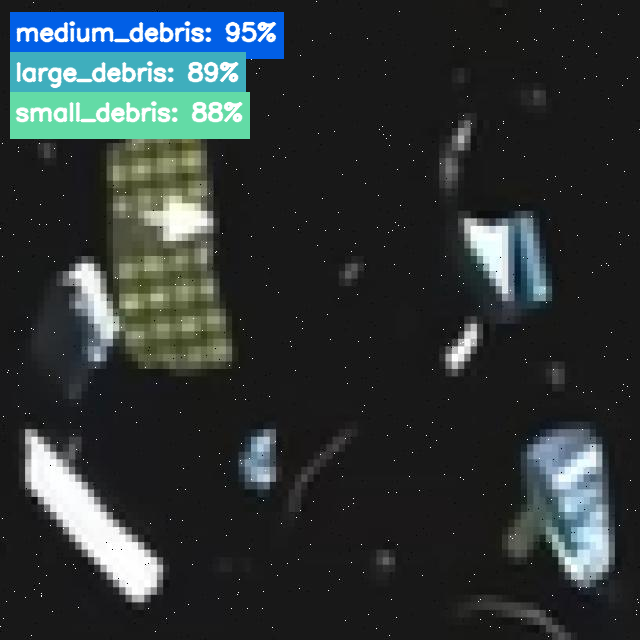


1 large_debris, 1 medium_debris
Latency: imload 2ms, preprocess 1ms, inference 0ms, postprocess 0ms, annotate 1ms, total 4ms


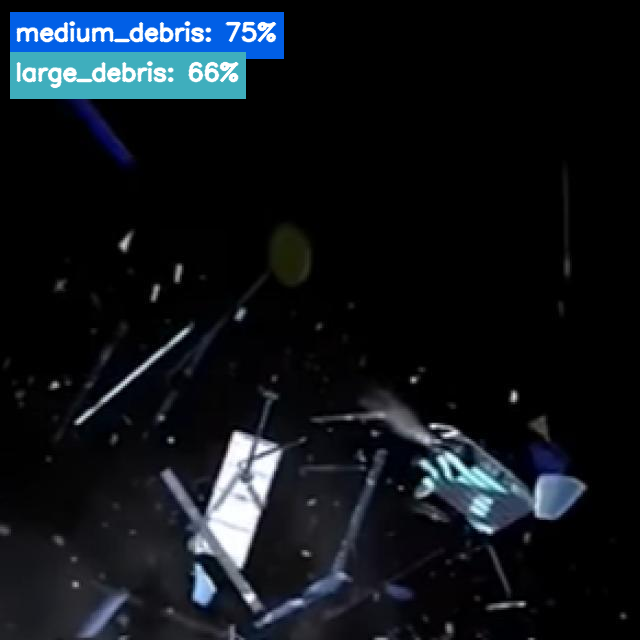


1 satellite
Latency: imload 2ms, preprocess 1ms, inference 0ms, postprocess 0ms, annotate 0ms, total 3ms


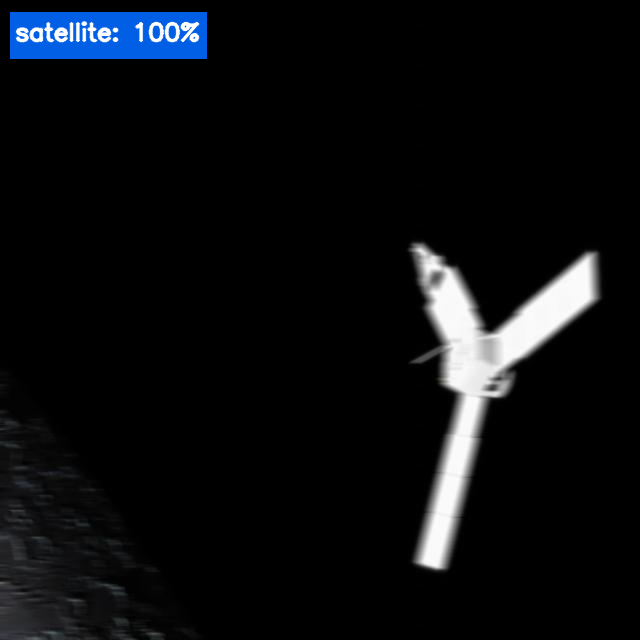


1 large_debris, 1 medium_debris
Latency: imload 2ms, preprocess 1ms, inference 1ms, postprocess 0ms, annotate 2ms, total 6ms


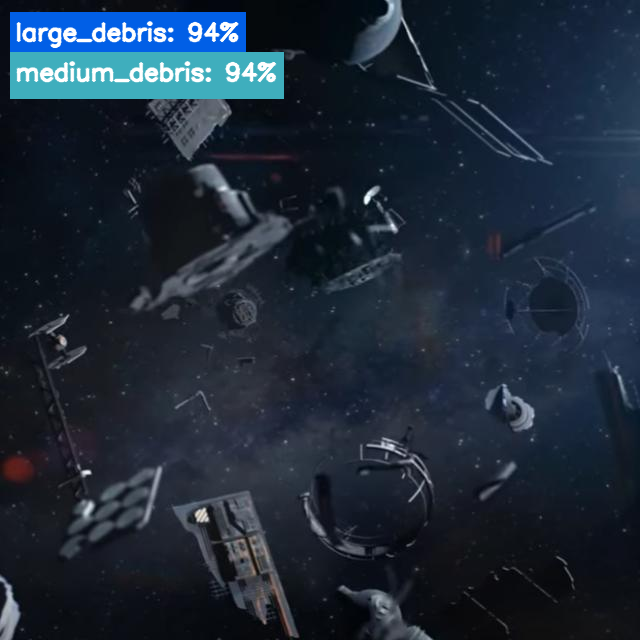

In [14]:
from IPython.display import display

quantized_model = InferModel(model_path, runtime_type=RuntimeType.ONNX_CPU)

for path in os.listdir(os.path.join(CALIBRATION_DIR, "test_imgs")):
    result = quantized_model.infer(os.path.join(CALIBRATION_DIR, "test_imgs", path), 
                                            annotate=True, threshold=0.65)
    img = Image.fromarray(result.image)
    display(img)